# Intro

## imports

In [1]:
import numpy as np
import tensorflow as tf

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import visualkeras as vk
tf.__version__

'2.12.0'

## definitions

In [2]:
%%capture

# Custom functions: add to lesson notebook instead of file
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath("./Functions/"))

import ann_functions as af

## Geting the source code for functions to display in notebook (for convenience)
import inspect
from IPython.display import Markdown, display
source_code = inspect.getsource(af)
display(Markdown(f"```python\n{source_code}\n```"))

In [39]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False,
                                    class_labels=None):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data',
                                              class_labels=class_labels)
        
    

    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data',
                                             class_labels=class_labels)




In [42]:
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes

In [48]:
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f",
                           class_labels=None):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0],
                                           display_labels=class_labels);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1],
                                            display_labels=class_labels);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=class_labels)
        return report_dict

def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False,
                                    class_labels=None):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data',
                                              class_labels=class_labels)
        
    

    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data',
                                             class_labels=class_labels)




## config

In [3]:
# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

# Create TensorFlow Image Dataset

In [4]:
# Checking the contents of xrays folder
data_dir = "Data/xrays/"
data_dir

'Data/xrays/'

In [5]:
# Getting list of img file paths (ONLY, did not make recursuve so no folders)
img_files = glob.glob(data_dir+"**/*")#, recursive=True)
len(img_files)

6939

In [6]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(751, 873, 3)

In [7]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 128
img_width = 128

In [8]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

ds

Found 6902 files belonging to 3 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [9]:
len(ds)

216

In [10]:
## Set the size of the splits
split_train = 0.7
split_val = 0.2
split_test = 0.1

# Calculate the number of batches for training and validation data 
n_train_batches =  int(len(ds) * split_train)
n_val_batches = int(len(ds) * split_val)

print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 151 batches as training data
Use 43 batches as validation data
The remaining 22 batches will be used as test data.


In [11]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
len(train_ds)

151

In [12]:
## Create the val_ds from original ds

# 1. Skipping over the training batches
val_ds = ds.skip(n_train_batches)

# 2. Taking the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
len(val_ds)

43

In [13]:
# Create the test split from ds

# SKip over all of the training + val images
test_ds = ds.skip(n_train_batches + n_val_batches)
len(test_ds)

22

In [14]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

216

# Optimize the Dataset

In [15]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# ORIGINAL SHUFFLED TRAIN
train_ds = train_ds.cache().shuffle(buffer_size= len(train_ds),
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
ds_val = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preview the Data and Save the Shape

In [16]:
# checking the class names
class_names = ds.class_names

class_dict = dict(zip(range(len(class_names)), class_names))
class_dict

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [17]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

3

In [18]:
# Batch Size
batch_size

32

In [19]:
%%time

# taking a sample banch to see batch shape
example_batch_imgs, example_batch_y= train_ds.take(1).get_single_element()
example_batch_imgs.shape

CPU times: total: 55 s
Wall time: 22.2 s


TensorShape([32, 128, 128, 3])

In [20]:
# individual image shape

input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([128, 128, 3])

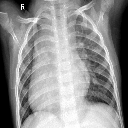

In [21]:
array_to_img(example_batch_imgs[0])

In [22]:
[*input_shape]

[128, 128, 3]

# Modeling

## Training Baseline CNN

In [23]:
def build_model1(name="CNN1", input_shape=input_shape):
    model = models.Sequential(name=name)
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1.0 / 255, input_shape=input_shape))

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding="same",
        )
    )
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding="same",
        )
    )
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(
            len(class_names), activation="softmax"
        )  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    model.summary()
    return model

## Model 1: Baseline Model

In [24]:
%%time

# Build fresh model and train
model1 = build_model1(name="Model1")

# fit the neural network
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    # epochs=5,
    callbacks=tf.keras.callbacks.EarlyStopping(
        mode="min", patience=5, restore_best_weights=True
    ),
)

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0    

151/151 [==============================] - 71s 464ms/step - loss: 0.6149 - accuracy: 0.7585 - val_loss: 0.4206 - val_accuracy: 0.8677
Epoch 2/5
151/151 [==============================] - 61s 402ms/step - loss: 0.3651 - accuracy: 0.8773 - val_loss: 0.3846 - val_accuracy: 0.8772
Epoch 3/5
151/151 [==============================] - 67s 445ms/step - loss: 0.3179 - accuracy: 0.8891 - val_loss: 0.3444 - val_accuracy: 0.8772
Epoch 4/5
151/151 [==============================] - 59s 390ms/step - loss: 0.2666 - accuracy: 0.9096 - val_loss: 0.3526 - val_accuracy: 0.8626
Epoch 5/5
151/151 [==============================] - 58s 383ms/step - loss: 0.2303 - accuracy: 0.9259 - val_loss: 0.3072 - val_accuracy: 0.9033


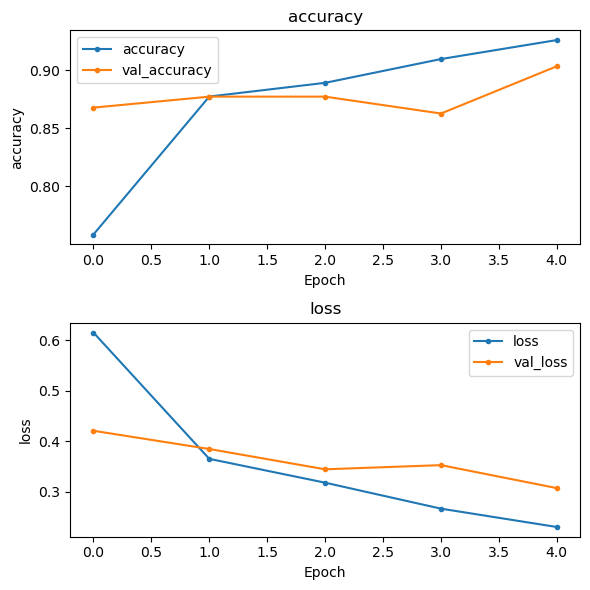


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1592
           1       0.92      0.93      0.93      1622
           2       0.93      0.94      0.94      1618

    accuracy                           0.94      4832
   macro avg       0.94      0.94      0.94      4832
weighted avg       0.94      0.94      0.94      4832



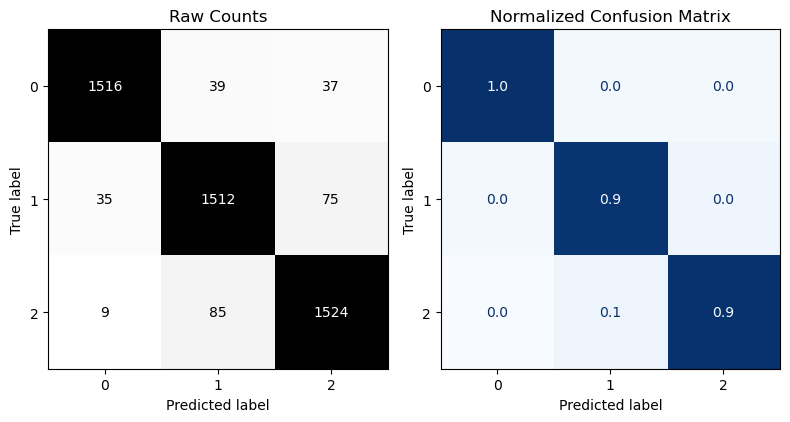


- Evaluating Training Data:
151/151 [==============================] - 10s 68ms/step - loss: 0.1817 - accuracy: 0.9421
{'loss': 0.1816859096288681, 'accuracy': 0.942052960395813}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       232
           1       0.88      0.85      0.87       241
           2       0.84      0.90      0.87       221

    accuracy                           0.88       694
   macro avg       0.88      0.88      0.88       694
weighted avg       0.88      0.88      0.88       694



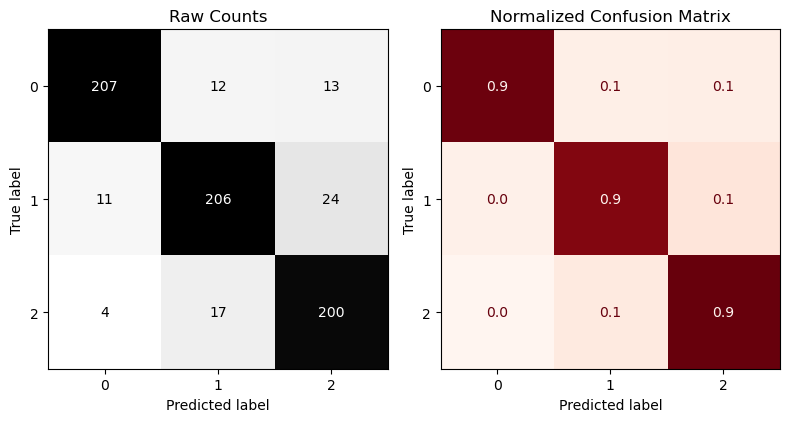


- Evaluating Test Data:
22/22 [==============================] - 30s 138ms/step - loss: 0.3051 - accuracy: 0.8847
{'loss': 0.30511200428009033, 'accuracy': 0.8847262263298035}


In [25]:
# Use evaluation function
af.evaluate_classification_network(
    model1, 
    X_train=train_ds,
    X_test=test_ds,
    history=history,
    figsize=(8, 8),
    values_format=".1f",
);

In [52]:
# Model 1
## Save the model

model1.save('Models/model1')

INFO:tensorflow:Assets written to: Models/model1\assets


INFO:tensorflow:Assets written to: Models/model1\assets


## Model 2

In [26]:
def build_model2(name="CNN2", input_shape=input_shape):
    model = models.Sequential(name=name)
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1.0 / 255, input_shape=input_shape))

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding="same",
        )
    )
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=5,  # size of each filter
            input_shape=input_shape,
            padding="same",
        )
    )
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding="same",
        )
    )
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(
            len(class_names), activation="softmax"
        )  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    model.summary()
    return model

In [27]:
%%time

# Build fresh model and train
model2 = build_model2(name="Model2")

# fit the neural network
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    # epochs=5,
    callbacks=tf.keras.callbacks.EarlyStopping(
        mode="min", patience=5, restore_best_weights=True
    ),
)

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248 

151/151 [==============================] - 83s 539ms/step - loss: 0.6457 - accuracy: 0.7318 - val_loss: 0.4569 - val_accuracy: 0.8576
Epoch 2/5
151/151 [==============================] - 80s 530ms/step - loss: 0.4085 - accuracy: 0.8630 - val_loss: 0.4149 - val_accuracy: 0.8576
Epoch 3/5
151/151 [==============================] - 83s 552ms/step - loss: 0.3399 - accuracy: 0.8909 - val_loss: 0.3359 - val_accuracy: 0.8953
Epoch 4/5
151/151 [==============================] - 86s 569ms/step - loss: 0.3016 - accuracy: 0.9015 - val_loss: 0.4262 - val_accuracy: 0.8626
Epoch 5/5
151/151 [==============================] - 118s 782ms/step - loss: 0.2670 - accuracy: 0.9127 - val_loss: 0.3188 - val_accuracy: 0.9012


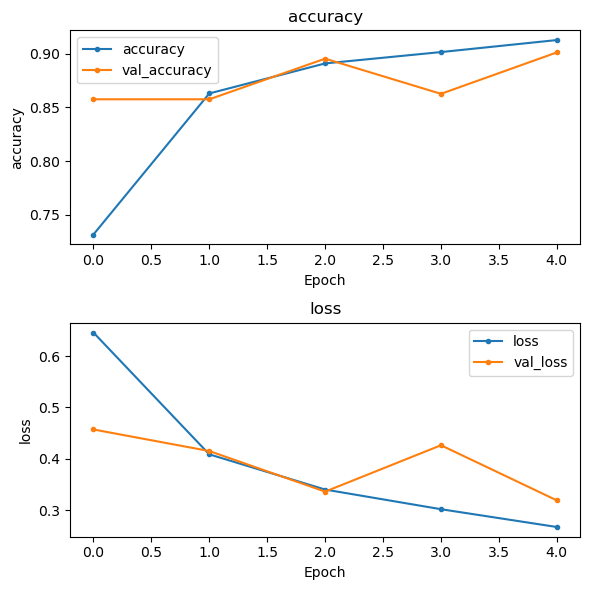


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1592
           1       0.89      0.95      0.92      1622
           2       0.96      0.91      0.94      1618

    accuracy                           0.93      4832
   macro avg       0.93      0.93      0.93      4832
weighted avg       0.93      0.93      0.93      4832



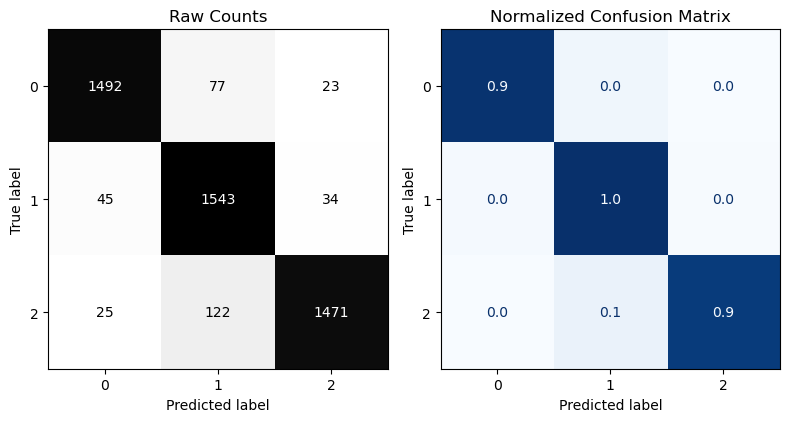


- Evaluating Training Data:
151/151 [==============================] - 17s 112ms/step - loss: 0.2209 - accuracy: 0.9325
{'loss': 0.22088223695755005, 'accuracy': 0.9325330853462219}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       219
           1       0.87      0.93      0.90       256
           2       0.93      0.89      0.91       219

    accuracy                           0.91       694
   macro avg       0.91      0.91      0.91       694
weighted avg       0.91      0.91      0.91       694



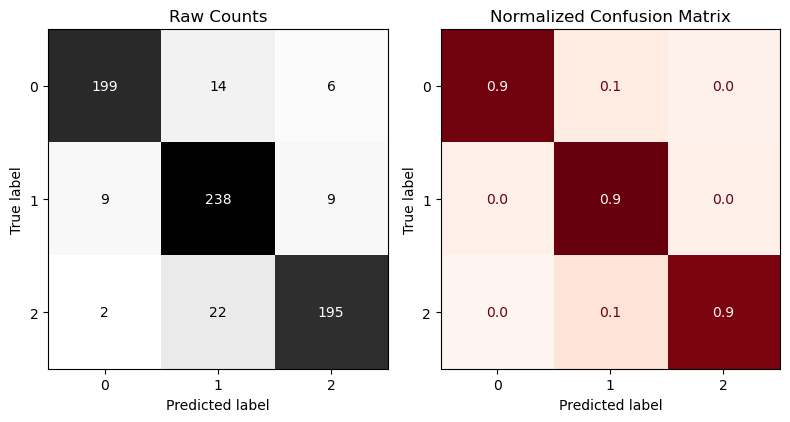


- Evaluating Test Data:
22/22 [==============================] - 49s 211ms/step - loss: 0.3124 - accuracy: 0.9020
{'loss': 0.31244179606437683, 'accuracy': 0.9020172953605652}


In [28]:
# Use evaluation function
af.evaluate_classification_network(
    model2, 
    X_train=train_ds,
    X_test=test_ds,
    history=history,
    figsize=(8, 20),
    values_format=".1f",
);

In [51]:
## Save the model

model2.save('Models/model2')

INFO:tensorflow:Assets written to: Models/model2\assets


INFO:tensorflow:Assets written to: Models/model2\assets


In [29]:
!pip install --force-reinstall -v "pillow<=9.5.0"

Using pip 23.2.1 from C:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\pip (python 3.10)
  Obtaining dependency information for pillow<=9.5.0 from https://files.pythonhosted.org/packages/3e/14/0030e542f2acfea43635e55584c114e6cfd94d342393a5f71f74c172dc35/Pillow-9.5.0-cp310-cp310-win_amd64.whl.metadata
  Using cached Pillow-9.5.0-cp310-cp310-win_amd64.whl.metadata (9.7 kB)
Using cached Pillow-9.5.0-cp310-cp310-win_amd64.whl (2.5 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Removing file or directory c:\users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\pil\
      Removing file or directory c:\users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\pillow-9.5.0.dist-info\
      Successfully uninstalled Pillow-9.5.0


ERROR: Could not install packages due to an OSError.
Consider using the `--user` option or check the permissions.
Traceback (most recent call last):
  File "C:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\pip\_internal\commands\install.py", line 452, in run
    installed = install_given_reqs(
  File "C:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\pip\_internal\req\__init__.py", line 88, in install_given_reqs
    uninstalled_pathset.commit()
  File "C:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\pip\_internal\req\req_uninstall.py", line 432, in commit
    self._moved_paths.commit()
  File "C:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\pip\_internal\req\req_uninstall.py", line 278, in commit
    save_dir.cleanup()
  File "C:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup
    rmtree(self._path)
  File "C:\Users\dsdye\anaconda3\envs\dojo-env\lib\site-packages\pip\_vendor\tenacity\__init__.

## Model 3 - Transfer Learning

In [30]:
def build_model3(name="CNN3", input_shape=input_shape):
    model = models.Sequential(name=name)
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1.0 / 255, input_shape=input_shape))

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding="same",
        )
    )
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=5,  # size of each filter
            input_shape=input_shape,
            padding="same",
        )
    )
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding="same",
        )
    )
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(
            len(class_names), activation="softmax"
        )  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    model.summary()
    return model

In [31]:
%%time

## Load the model.
pretrained = tf.keras.applications.InceptionV3( input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet',
                                                classes=num_classes )

pretrained.trainable=False
preprocessing = tf.keras.applications.xception.preprocess_input

CPU times: total: 3.92 s
Wall time: 8.83 s


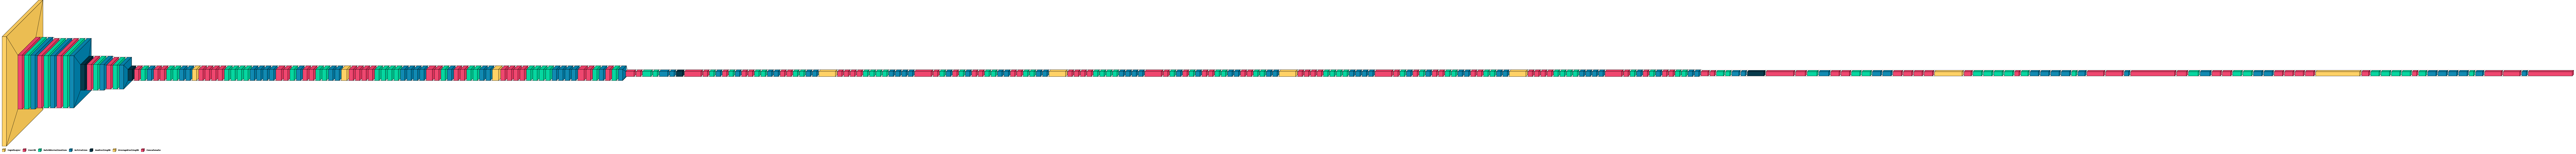

In [32]:
vk.layered_view(pretrained, legend=True)

In [33]:
def build_transfer_model():

    ## Initialize Model
    model = models.Sequential()

    ## Add input layer
    model.add(layers.Input(shape=input_shape, name='input'))

    ## Add the preprocessing layer
    model.add(layers.Lambda(preprocessing, name='preprocessing'))

    ## Add the pretrained layers
    model.add(pretrained)

    ## Flatten the Data
    model.add(layers.Flatten())
    
    ## Add a dropout layer for regularization
    model.add(layers.Dense(32))
    model.add(layers.Dense(32))
    
    ## Add the output layer
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    
    ## Complile the model and return it.
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    display(model.summary())
    return model

In [44]:
%%time

## fit the model
transfer_model = build_transfer_model()



history = transfer_model.fit(ds_val,
                              validation_data=ds_test,
                              epochs=20,
                              callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
                            )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Lambda)      (None, 128, 128, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                262176    
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 3)                 99        
                                                                 
Total params: 22,066,115
Trainable params: 263,331
Non

None

Epoch 1/25
43/43 [==============================] - 215s 4s/step - loss: 3.1963 - accuracy: 0.7304 - val_loss: 0.7457 - val_accuracy: 0.8458
Epoch 2/25
43/43 [==============================] - 97s 2s/step - loss: 0.3811 - accuracy: 0.8924 - val_loss: 0.7793 - val_accuracy: 0.8487
Epoch 3/25
43/43 [==============================] - 100s 2s/step - loss: 0.2012 - accuracy: 0.9346 - val_loss: 0.7424 - val_accuracy: 0.8545
Epoch 4/25
43/43 [==============================] - 120s 3s/step - loss: 0.1173 - accuracy: 0.9535 - val_loss: 0.6098 - val_accuracy: 0.8746
Epoch 5/25
43/43 [==============================] - 132s 3s/step - loss: 0.0950 - accuracy: 0.9644 - val_loss: 0.7307 - val_accuracy: 0.8790
Epoch 6/25
43/43 [==============================] - 121s 3s/step - loss: 0.0703 - accuracy: 0.9753 - val_loss: 0.8766 - val_accuracy: 0.8689
Epoch 7/25
43/43 [==============================] - 133s 3s/step - loss: 0.0597 - accuracy: 0.9746 - val_loss: 0.9369 - val_accuracy: 0.8631
Epoch 8/25
43/

In [45]:
## Save the model

transfer_model.save('Models/transfer_model')

INFO:tensorflow:Assets written to: Models/transfer_model\assets


INFO:tensorflow:Assets written to: Models/transfer_model\assets


In [46]:
loaded_model = tf.keras.models.load_model('Models/transfer_model')

In [49]:
# Evaluate the model
evaluate_classification_network(loaded_model, X_train=ds_val, X_test=ds_test, history=history,
                                           figsize=(12,8), class_labels=class_names)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       0.85      1.00      0.92       470
      normal       1.00      0.77      0.87       441
   pneumonia       0.95      1.00      0.97       465

    accuracy                           0.93      1376
   macro avg       0.94      0.92      0.92      1376
weighted avg       0.93      0.93      0.92      1376



AttributeError: module 'PIL' has no attribute 'Image'

AttributeError: module 'PIL' has no attribute 'Image'

<Figure size 600x600 with 2 Axes>

AttributeError: module 'PIL' has no attribute 'Image'

<Figure size 1200x800 with 2 Axes>

In [50]:
# Evaluate the model
evaluate_classification_network(loaded_model, X_train=ds_val, X_test=ds_test, history=history,
                                           figsize=(12,8), class_labels=class_names)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       0.85      1.00      0.92       470
      normal       1.00      0.77      0.87       441
   pneumonia       0.95      1.00      0.97       465

    accuracy                           0.93      1376
   macro avg       0.94      0.92      0.92      1376
weighted avg       0.93      0.93      0.92      1376



AttributeError: module 'PIL' has no attribute 'Image'

AttributeError: module 'PIL' has no attribute 'Image'

<Figure size 600x600 with 2 Axes>

AttributeError: module 'PIL' has no attribute 'Image'

<Figure size 1200x800 with 2 Axes>


================================================================================
- Evaluating Network...
================================================================================
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       0.85      1.00      0.92       470
      normal       1.00      0.77      0.87       441
   pneumonia       0.95      1.00      0.97       465

    accuracy                           0.93      1376
   macro avg       0.94      0.92      0.92      1376
weighted avg       0.93      0.93      0.92      1376



# Choose Best Model

Model 1

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       232
           1       0.88      0.85      0.87       241
           2       0.84      0.90      0.87       221

    accuracy                           0.88       694
   macro avg       0.88      0.88      0.88       694
weighted avg       0.88      0.88      0.88       694

Model 2

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       219
           1       0.87      0.93      0.90       256
           2       0.93      0.89      0.91       219

    accuracy                           0.91       694
   macro avg       0.91      0.91      0.91       694
weighted avg       0.91      0.91      0.91       694

Best model: Model 2